In [308]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm

# Setup Environment

Given that at each timestep the user will observe a distance and speed of the vehicle we generate an array of noisy distance and speed values for an appoaching car based on its true distance and speed.

In [309]:
n_obs = 20  # Distance to pass the user
intial_true_distance = 15
true_speed = 1
true_distances = []  # Create array of true distances for each timestep
for i in range(n_obs):
    true_distances.append(intial_true_distance - i*true_speed)
observed_distances = [np.random.normal(true_distances[i], 1) for i in range(n_obs)]  # sample from normal with mean true_distance and std 1
observed_speeds = [np.random.normal(1, 0.5) for i in range(n_obs)]  # sample from normal with mean true_distance and std 0.5

# Setup Model

We predict the noise in the distance (as the distance keeps changing) and the speed (which is constant) .

The speed is inferred by a normal distribution that is updated using Bayes theorem with PyMC based on the observed speeds. 

$$ p(\theta | v) = \frac{p(\theta) p(v | \theta)}{\int{p(\theta) p(v | \theta)}} \propto p(\theta) p(v | \theta) $$

Where $\theta$ is the paramaters of the speed ($v$) distribution ($\mu_v$ and $\sigma_v$ ) and $v$ is the observed speeds.

The distance is inferred by the addition of the current distance observation plus the modelled noise which is based on the difference between the predicted current location and the observed current location.
The predicted current location is given by the previous location minus the inferred speed. Given the speed is constant we use the most up to date speed inferrance. 

$$ {\eta}_d = d_{o, t} - d_{p, t} $$
$$ d_{p, t} = d_{o, t-1} - \mu_v $$
$$ {\eta}_d = d_{o, t} - (d_{o, t-1} - \mu_v) $$

$$ p(\theta | {\eta}_d) = \frac{p(\theta) p({\eta}_d | \theta)}{\int{p(\theta) p({\eta}_d | \theta)}} \propto p(\theta) p({\eta}_d | \theta) $$

Where ${\eta}_d$ is the noise in $d$, $d_{o, t}$ is the distance observation at time $t$, $d_{p, t}$ is the predicted distance at $t$, and $\mu_v$ is the mean predicted speed, and $\theta$ is the paramaters $\mu_\eta$ and $\sigma_\eta$ of the distance noise (${\eta}_d$) distribution.   


The probability of safe crossing is then given by the probability of the vehicle being at less than 5 within the time to cross the road (which is 5 timesteps)

$$ p(safe) = (d_{o,t} + \eta_d)-(\mu_d \cdot t_{cross}) > t_{cross} $$

Where $p(safe)$ is the probability of crossing safely, and $t_{cross}$ is the time it takes for the user to cross the road, all other symbols are as before.

The model needs to have 2 observations, the current and the previous. So the model defined here uses the first two timesteps. 


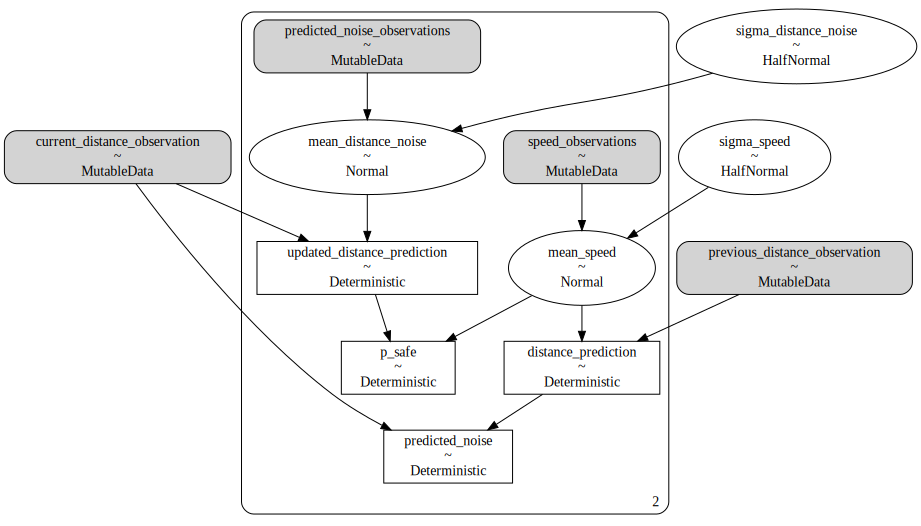

In [311]:
import pytensor

with pm.Model() as car_model:
    # Modelling speed
    speed_observations = pm.MutableData('speed_observations', observed_speeds[:2])
    sigma_speed = pm.HalfNormal('sigma_speed', sigma=2)
    mean_speed = pm.Normal('mean_speed', speed_observations, sigma_speed)

    # Modelling the noise in the distance
    previous_distance_observation = pm.MutableData('previous_distance_observation', observed_distances[0])
    current_distance_observation = pm.MutableData('current_distance_observation', observed_distances[1])
    distance_prediction = pm.Deterministic('distance_prediction', previous_distance_observation-mean_speed)

    predicted_noise = pm.Deterministic('predicted_noise', current_distance_observation-distance_prediction)
    predicted_noise_observations = pm.MutableData('predicted_noise_observations', [0., 0.])
    sigma_distance_noise = pm.HalfNormal('sigma_distance_noise', sigma=2)
    mean_distance_noise = pm.Normal('mean_distance_noise', predicted_noise_observations, sigma_distance_noise)

    updated_distance_prediction = pm.Deterministic('updated_distance_prediction', current_distance_observation+mean_distance_noise)

    p_safe = pm.Deterministic('p_safe', updated_distance_prediction-(mean_speed*5) > 5)   

pm.model_to_graphviz(car_model)

# Run Model

To run the model all the speed observations are put into the model for the speed prediction, only the current and previous distances are put into the model as previous distances are irrelevant for current distance prediction. All the previous noise models are added to the model as the model needs a memory of the previous noise values, and the new noise is added to the array of noises.

This is looped over from the start distance until the vehicle has passed the user

In [312]:
chains = 10
draws = 1000
cores = 10

pdatas = []
idatas = []
noises = np.array([0, 0])
for i in range(1,n_obs):
  print(f'Running {i} --------------------------------------')
  with car_model:
    pm.set_data({'speed_observations': np.random.choice(observed_speeds[:i+1], len(noises))})
    pm.set_data({'current_distance_observation': observed_distances[i]})
    pm.set_data({'previous_distance_observation': observed_distances[i-1]})
    pm.set_data({'predicted_noise_observations': noises})
    idata = pm.sample(chains=chains, draws=draws, cores=cores)
    idatas.append(idata)
    pdata = pm.sample_posterior_predictive(idata)
    pdatas.append(pdata)
    noises = np.append(noises, np.mean(idata.posterior.predicted_noise.values.reshape(1, -1)[0]))


Running 1 --------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [sigma_speed, mean_speed, sigma_distance_noise, mean_distance_noise]


Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 7 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1022 divergences after tuning. Increase `target_accept` or reparameterize.


Running 2 --------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [sigma_speed, mean_speed, sigma_distance_noise, mean_distance_noise]


Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 8 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 734 divergences after tuning. Increase `target_accept` or reparameterize.


Running 3 --------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [sigma_speed, mean_speed, sigma_distance_noise, mean_distance_noise]


Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 414 divergences after tuning. Increase `target_accept` or reparameterize.


Running 4 --------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [sigma_speed, mean_speed, sigma_distance_noise, mean_distance_noise]


Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 320 divergences after tuning. Increase `target_accept` or reparameterize.


Running 5 --------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [sigma_speed, mean_speed, sigma_distance_noise, mean_distance_noise]


Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 805 divergences after tuning. Increase `target_accept` or reparameterize.


Running 6 --------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [sigma_speed, mean_speed, sigma_distance_noise, mean_distance_noise]


Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 175 divergences after tuning. Increase `target_accept` or reparameterize.


Running 7 --------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [sigma_speed, mean_speed, sigma_distance_noise, mean_distance_noise]


Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 12 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 270 divergences after tuning. Increase `target_accept` or reparameterize.


Running 8 --------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [sigma_speed, mean_speed, sigma_distance_noise, mean_distance_noise]


Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 86 divergences after tuning. Increase `target_accept` or reparameterize.


Running 9 --------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [sigma_speed, mean_speed, sigma_distance_noise, mean_distance_noise]


Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 17 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 286 divergences after tuning. Increase `target_accept` or reparameterize.


Running 10 --------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [sigma_speed, mean_speed, sigma_distance_noise, mean_distance_noise]


Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 153 divergences after tuning. Increase `target_accept` or reparameterize.


Running 11 --------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [sigma_speed, mean_speed, sigma_distance_noise, mean_distance_noise]


Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 15 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.


Running 12 --------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [sigma_speed, mean_speed, sigma_distance_noise, mean_distance_noise]


Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 25 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 434 divergences after tuning. Increase `target_accept` or reparameterize.


Running 13 --------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [sigma_speed, mean_speed, sigma_distance_noise, mean_distance_noise]


Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 15 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 786 divergences after tuning. Increase `target_accept` or reparameterize.


Running 14 --------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [sigma_speed, mean_speed, sigma_distance_noise, mean_distance_noise]


Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 20 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1140 divergences after tuning. Increase `target_accept` or reparameterize.


Running 15 --------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [sigma_speed, mean_speed, sigma_distance_noise, mean_distance_noise]


Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 16 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 379 divergences after tuning. Increase `target_accept` or reparameterize.


Running 16 --------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [sigma_speed, mean_speed, sigma_distance_noise, mean_distance_noise]


Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 21 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 421 divergences after tuning. Increase `target_accept` or reparameterize.


Running 17 --------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [sigma_speed, mean_speed, sigma_distance_noise, mean_distance_noise]


Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 19 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.


Running 18 --------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [sigma_speed, mean_speed, sigma_distance_noise, mean_distance_noise]


Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 24 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 276 divergences after tuning. Increase `target_accept` or reparameterize.


Running 19 --------------------------------------


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [sigma_speed, mean_speed, sigma_distance_noise, mean_distance_noise]


Sampling 10 chains for 1_000 tune and 1_000 draw iterations (10_000 + 10_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 615 divergences after tuning. Increase `target_accept` or reparameterize.


# Plotting results

The plots below are: 
- predicted and actual distances for each time step 
- noise prediction for each time step
- speed prediction for each time step
- probability of crossing safely at each timestep

In [363]:
def get_confidence_intervals(data):
    indicies = ['2.5','25','50','75','97.5']
    CI = {}
    for index in indicies:
        CI[index] = []
    [
        (CI['2.5'].append(i[0]), CI['25'].append(i[1]), CI['50'].append(i[2]), CI['75'].append(i[3]), CI['97.5'].append(i[4])) 
        for i in [np.quantile(datum, [0.025,0.25,0.5,0.75,0.975], axis=0) for datum in data]
    ]
    for index in indicies:
        CI[index] = np.array(CI[index]).flatten()
    return CI

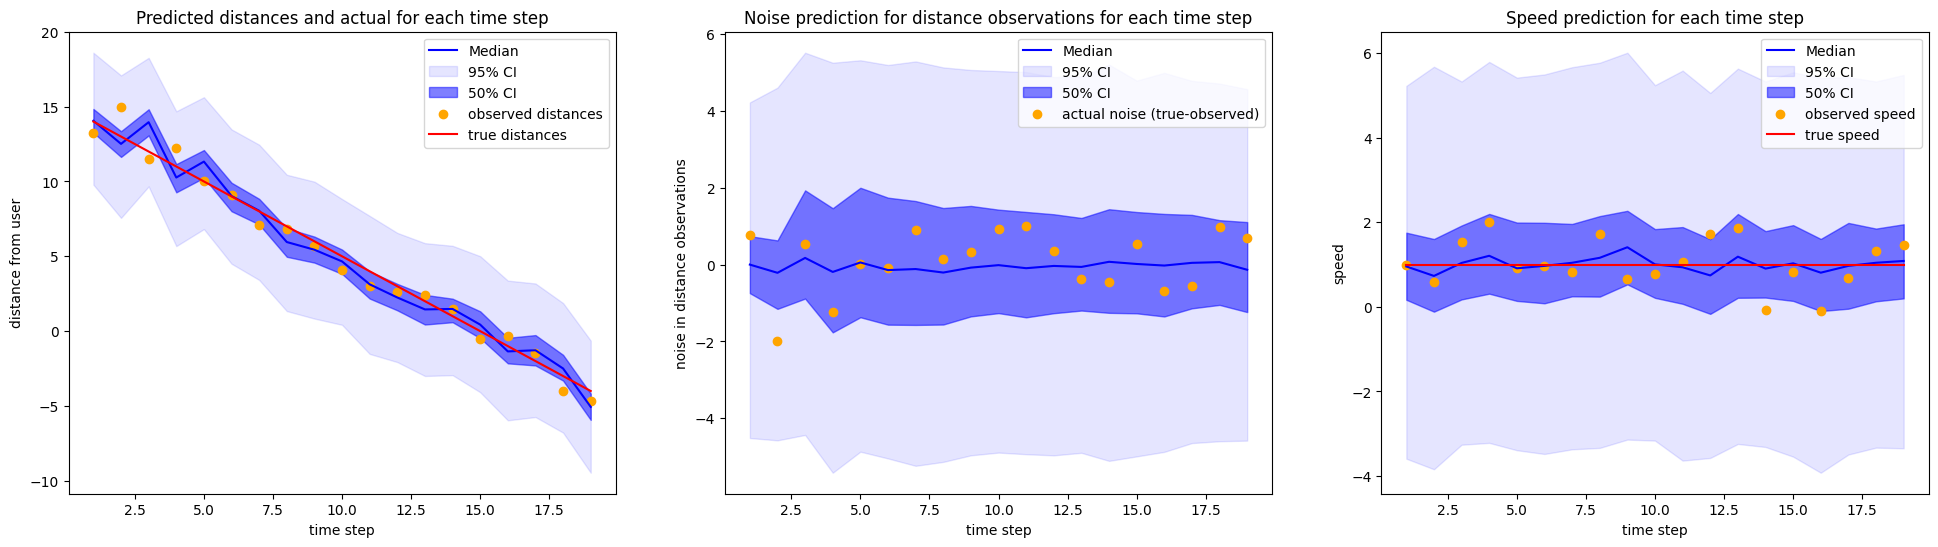

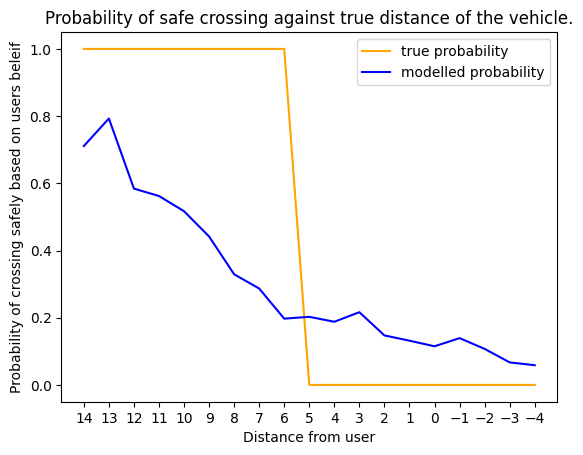

In [389]:
t = [i for i in range(1, n_obs)]
fig, axes = plt.subplots(1, 3, figsize=(8*3, 6))

# Predicted and actual distances for each time step 
ax = axes[0]
## Plot median and CI
predicted_distances = [idata.posterior.distance_prediction.values.reshape(-1, 1) for idata in idatas]
confidence_intervals = get_confidence_intervals(predicted_distances)
ax.plot(t, confidence_intervals['50'], color='blue', label='Median')
ax.fill_between(t, confidence_intervals['2.5'], confidence_intervals['97.5'], color='blue', alpha=0.1, label='95% CI')
ax.fill_between(t, confidence_intervals['25'], confidence_intervals['75'], color='blue', alpha=0.5, label='50% CI')
## Plot actual and observed 
ax.scatter(x=t, y=observed_distances[1:n_obs], label='observed distances', color='orange')
ax.plot(t, true_distances[1:n_obs], label='true distances', color='red')
## Configure title, axes labels, and legend 
ax.set_title('Predicted distances and actual for each time step')
ax.set_xlabel('time step')
ax.set_ylabel('distance from user')
ax.legend()


# Noise prediction for each time step
ax = axes[1]
noises = [idata.posterior.mean_distance_noise.values.reshape(-1, 1) for idata in idatas]
confidence_intervals = get_confidence_intervals(noises)
ax.plot(t, confidence_intervals['50'], color='blue', label='Median')
ax.fill_between(t, confidence_intervals['2.5'], confidence_intervals['97.5'], color='blue', alpha=0.1, label='95% CI')
ax.fill_between(t, confidence_intervals['25'], confidence_intervals['75'], color='blue', alpha=0.5, label='50% CI')
## Plot actual noise
ax.scatter(x=t, y=np.array(true_distances[1:n_obs])-np.array(observed_distances[1:n_obs]), label='actual noise (true-observed)', color='orange')
## Configure title, axes labels, and legend 
ax.set_title('Noise prediction for distance observations for each time step')
ax.set_xlabel('time step')
ax.set_ylabel('noise in distance observations')
ax.legend()


# Speed prediction for each time step
ax = axes[2]
speeds = [idata.posterior.mean_speed.values.reshape(-1, 1) for idata in idatas]
confidence_intervals = get_confidence_intervals(speeds)
ax.plot(t, confidence_intervals['50'], color='blue', label='Median')
ax.fill_between(t, confidence_intervals['2.5'], confidence_intervals['97.5'], color='blue', alpha=0.1, label='95% CI')
ax.fill_between(t, confidence_intervals['25'], confidence_intervals['75'], color='blue', alpha=0.5, label='50% CI')
ax.scatter(t, observed_speeds[1:n_obs], color='orange', label='observed speed')
ax.plot(t, np.ones(n_obs-1), color='red', label='true speed')

## Configure title, axes labels, and legend 
ax.set_title('Speed prediction for each time step')
ax.set_xlabel('time step')
ax.set_ylabel('speed')
ax.legend()


# - the probability of crossing safely at each timestep
safe_percents = []
d=[]
true_prob = []
for i in range(n_obs-1):
    d.append(14-i)
    safe = idatas[i].posterior.p_safe.values.reshape(1, -1)[0]
    safe_percents.append(np.count_nonzero(safe)/len(safe))
    if i > 8:
        true_prob.append(0)
    else:
        true_prob.append(1)

fig, ax = plt.subplots()
ax.plot(d, true_prob, label='true probability', color='orange')
ax.plot(d, safe_percents, label='modelled probability', color='blue')
ax.invert_xaxis()
ax.set_title("Probability of safe crossing against true distance of the vehicle.")
ax.set_xlabel('Distance from user')
ax.set_ylabel('Probability of crossing safely based on users beleif')
ax.set_xticks(d)
ax.legend()